<a href="https://colab.research.google.com/github/aim56009/AI-MA_project/blob/main/Masterproject_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports 

In [18]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import torchvision.transforms.functional as TF 

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import os

import random
import click
import sklearn
import sklearn.model_selection
from collections import defaultdict
from sklearn.metrics import accuracy_score
from pathlib import Path
import sys
from torch import optim
from torch.optim import lr_scheduler
from functools import partial
import matplotlib.pyplot as plt

In [19]:
!git clone https://github.com/aim56009/AI-MA_project.git

fatal: destination path 'AI-MA_project' already exists and is not an empty directory.


# Dataloader

In [20]:
batch_size = 1 
PATH_TO_DATA = "AI-MA_project/pianoroll"
workers = 0

In [21]:
class MusicDataset(Dataset):

    def __init__(self, data_dir, transforms=None):
        self.transforms = transforms
        self.data_dir = data_dir

        labels = ["voice_0", "voice_1", "voice_2", "voice_3", "voice_all"]
        self.labels = labels
        self.pr_dict = {}
        len_list = []

        for iLabel in range(len(labels)):
            
            if iLabel == 4:   
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl")))   
                for name in file_names:
                    with open(name ,'rb') as f: 
                        loaded_obj = pickle.load(f)  
                        voice_files.append(loaded_obj) 
                        len_list.append(len(loaded_obj.T))                             
                self.pr_dict[self.labels[iLabel]] = voice_files 
                self.pr_dict["length"] = len_list
            
            else:
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl")))   
                for name in file_names:
                    with open(name ,'rb') as f: 
                        loaded_obj = pickle.load(f)     
                        voice_files.append(loaded_obj)                              
                self.pr_dict[self.labels[iLabel]] = voice_files 
                                        

    def __len__(self):
      
        return len(self.pr_dict[self.labels[0]])

    def __getitem__(self, idx):          

        out_list = []
        for key, value in self.pr_dict.items():
            out_list.append(self.pr_dict[key][idx])                  
        v0 = torch.tensor(out_list[0].T)
        v1 = torch.tensor(out_list[1].T)
        v2 = torch.tensor(out_list[2].T)
        v3 = torch.tensor(out_list[3].T)
        v_all = torch.tensor(out_list[4].T) 
        length = self.pr_dict["length"][idx]

        return (v0, v1, v2, v3, v_all, length)

In [22]:
dataset = MusicDataset(PATH_TO_DATA)
loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

# Define Music - Model


Define UNET 

In [23]:
class UNET(nn.Module):
    
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
        
        concat_layers = concat_layers[::-1]
        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x 

In [24]:
class MusicNetwork(nn.Module):

    def __init__(self, network_type,output_dim=128, hidden_dim=300, rnn_depth=1, cell_type="GRU"):                 
        super(MusicNetwork, self).__init__()

        self.network_type = network_type
        self.n_out = output_dim
        input_dim = output_dim 
        rnn_cell = nn.GRU
        self.rnn = rnn_cell(input_size=input_dim, hidden_size=hidden_dim, num_layers=rnn_depth, batch_first=True)
        self.cnn = UNET(in_channels=1, classes=4)
        self.top_layer_voice_0 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_1 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_2 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_3 = nn.Linear(hidden_dim, self.n_out)
        self.loss = nn.CrossEntropyLoss(reduction="mean")

    def compute_outputs(self, sentences, sentences_len):
        if self.network_type == "RNN":
          rnn_out ,_= self.rnn(sentences)
          
          out_0 = self.top_layer_voice_0(rnn_out)
          out_1 = self.top_layer_voice_1(rnn_out)
          out_2 = self.top_layer_voice_2(rnn_out)
          out_3 = self.top_layer_voice_3(rnn_out)

        else: 
          sentences = sentences[:,None]
          out = self.cnn(sentences)
          out_0 = out[:,0,:]
          out_1 = out[:,1,:]
          out_2 = out[:,2,:]
          out_3 = out[:,3,:]


        return out_0, out_1, out_2, out_3

    def forward(self, sentences, v0, v1, v2, v3, sentences_len):                

        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores_0, scores_1, scores_2, scores_3 = self.compute_outputs(sentences, sentences_len)

        # Flatten the outputs and the labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        score_0  = scores_0.view(-1, self.n_out)
        score_1  = scores_1.view(-1, self.n_out)
        score_2  = scores_2.view(-1, self.n_out)
        score_3  = scores_3.view(-1, self.n_out)

        v0 = v0.squeeze()
        v1 = v1.squeeze()
        v2 = v2.squeeze()
        v3 = v3.squeeze()
        
        loss = self.loss(score_0, v0) + self.loss(score_1, v1) + self.loss(score_2, v2) + self.loss(score_3, v3)
        
        return loss

    def predict(self, sentences, sentences_len):

        # Compute the outputs from the linear units.
        scores_0, scores_1, scores_2, scores_3 = self.compute_outputs(sentences, sentences_len)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted_0 = scores_0.argmax(dim=2)
        predicted_1 = scores_1.argmax(dim=2)
        predicted_2 = scores_2.argmax(dim=2)
        predicted_3 = scores_3.argmax(dim=2)       
        
        return np.squeeze(predicted_0.cpu().numpy()), np.squeeze(predicted_1.cpu().numpy()), np.squeeze(predicted_2.cpu().numpy()), np.squeeze(predicted_3.cpu().numpy())

# Define Training Process

In [25]:
def train(epochs, lr, hidden_dim, momentum, rnn_depth, device, rnn_cell, weight_decay,network_type, train_dataloader, val_dataloader=None):
    
    output_dim = 128                                                            
    model = MusicNetwork(network_type, output_dim, hidden_dim, rnn_depth, cell_type)              
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.MultiStepLR(optimizer, [epochs // 2], gamma=0.1, verbose=True)

    history = training_loop(model, optimizer, train_dataloader, epochs=epochs, val_dataloader=val_dataloader, device=device, scheduler=scheduler)

    return model, history

In [26]:
def training_loop(model,optimizer, train_dataloader, epochs=50, val_dataloader=None, device=None, scheduler=None,):
    if device is None:
        device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        print(f"Training on device: {device}")

    model = model.to(device)
    history = defaultdict(list)

    for i_epoch in range(1, epochs + 1):
        loss_sum = 0
        accuracy_v0_sum = 0
        accuracy_v1_sum = 0
        accuracy_v2_sum = 0
        accuracy_v3_sum = 0
        accuracy_v_all_sum = 0
        model.train()
        

        for idx, (v0, v1, v2, v3, v_all, lens) in enumerate(train_dataloader):  
            
            v0, v1, v2, v3, v_all = (v0.to(device).float(), v1.to(device).float(), v2.to(device).float(), v3.to(device).float(), v_all.to(device).float())
          
            optimizer.zero_grad()
            loss = model.forward(v_all, v0, v1, v2, v3, lens)

            loss.backward()
            optimizer.step()
            loss_sum += loss.item()


            with torch.no_grad():
                pred_v0, pred_v1, pred_v2, pred_v3 = model.predict(v_all, lens)
               
                acc_v0 = accuracy_score(torch.tensor(pred_v0), np.squeeze(v0).argmax(dim=1).cpu())
                acc_v1 = accuracy_score(torch.tensor(pred_v1), np.squeeze(v1).argmax(dim=1).cpu())
                acc_v2 = accuracy_score(torch.tensor(pred_v2), np.squeeze(v2).argmax(dim=1).cpu())
                acc_v3 = accuracy_score(torch.tensor(pred_v3), np.squeeze(v3).argmax(dim=1).cpu())
                # normalize according to the number of sequences in the batch (atm len(lens)==1)
                accuracy_v0_sum += acc_v0 / len(lens)
                accuracy_v1_sum += acc_v1 / len(lens)
                accuracy_v2_sum += acc_v2 / len(lens)
                accuracy_v3_sum += acc_v3 / len(lens)

        train_loss = loss_sum / len(train_dataloader)

        # normalize according to the number of batches

        train_accuracy_v0 = accuracy_v0_sum / len(train_dataloader)
        train_accuracy_v1 = accuracy_v1_sum / len(train_dataloader)
        train_accuracy_v2 = accuracy_v2_sum / len(train_dataloader)
        train_accuracy_v3 = accuracy_v3_sum / len(train_dataloader)

        history["train_loss"].append(train_loss)
        history["train_accuracy_v0"].append(train_accuracy_v0)
        history["train_accuracy_v1"].append(train_accuracy_v1)
        history["train_accuracy_v2"].append(train_accuracy_v2)
        history["train_accuracy_v3"].append(train_accuracy_v3)
        
        print("Train Loss: {}, Train Accuracy_0 : {}, Train Accuracy_1 : {},Train Accuracy_2 : {}, Train Accuracy_3 : {}".format(train_loss, train_accuracy_v0, train_accuracy_v1, train_accuracy_v2, train_accuracy_v3)) 


        if val_dataloader is not None:
            # Evaluate on the validation set
            model.eval()
            accuracy_v0_sum = 0
            accuracy_v1_sum = 0
            accuracy_v2_sum = 0
            accuracy_v3_sum = 0

            with torch.no_grad():

                for v0, v1, v2, v3, v_all, lens in val_dataloader:

                    v0, v1, v2, v3, v_all = (v0.to(device).float(), v1.to(device).float(), v2.to(device).float(), v3.to(device).float(), v_all.to(device).float())

                    # Predict the model's output on a batch
                    pred_v0, pred_v1, pred_v2, pred_v3 = model.predict(v_all, lens)
                        
                    # compute the accuracy 
                    acc_v0 = accuracy_score(torch.tensor(pred_v0), np.squeeze(v0).argmax(dim=1).cpu())
                    acc_v1 = accuracy_score(torch.tensor(pred_v1), np.squeeze(v1).argmax(dim=1).cpu())
                    acc_v2 = accuracy_score(torch.tensor(pred_v2), np.squeeze(v2).argmax(dim=1).cpu())
                    acc_v3 = accuracy_score(torch.tensor(pred_v3), np.squeeze(v3).argmax(dim=1).cpu())
                        
                        
                    # normalize according to the number of sequences in the batch (atm len(lens)==1)
                    accuracy_v0_sum += acc_v0 / len(lens)
                    accuracy_v1_sum += acc_v1 / len(lens)
                    accuracy_v2_sum += acc_v2 / len(lens)
                    accuracy_v3_sum += acc_v3 / len(lens)

                # normalize according to the number of batches
                val_accuracy_v0 = accuracy_v0_sum / len(val_dataloader)
                val_accuracy_v1 = accuracy_v1_sum / len(val_dataloader)
                val_accuracy_v2 = accuracy_v2_sum / len(val_dataloader)
                val_accuracy_v3 = accuracy_v3_sum / len(val_dataloader)

            history["val_accuracy_v0"].append(val_accuracy_v0)
            history["val_accuracy_v1"].append(val_accuracy_v1)
            history["val_accuracy_v2"].append(val_accuracy_v2)
            history["val_accuracy_v3"].append(val_accuracy_v3)
            
            print(" Validation Accuracy_0 : {}, Validation Accuracy_1 : {}, Validation Accuracy_2 : {}, Validation Accuracy_3 : {}".format(val_accuracy_v0, val_accuracy_v1, val_accuracy_v2, val_accuracy_v3))

        if scheduler is not None:
            scheduler.step()

        # save the model
        torch.save(model, Path("./AI-MA_project/model_temp_epoch{}.pkl".format(i_epoch)))

    return history

In [27]:
def start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell, decay,network_type, learn_all):
    

    trainer = partial(train, epochs, lr, hidden_dim, momentum, rnn_depth, device, cell, decay, network_type)

    if learn_all == True:
        print("Learning from full dataset")
        train_dataset = MusicDataset(PATH_TO_DATA)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
                
        _, history = trainer(train_dataloader)

    
    else:
        # Divide train and validation set
        path_train, path_validation = sklearn.model_selection.train_test_split(PATH_TO_DATA, test_size=0.15, random_state=10,)

        print("Train and validation lenghts: ", len(path_train), len(path_validation))
        train_dataset = MusicDataset(path_train)
        validation_dataset = MusicDataset(path_validation)
        
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

        _, history = trainer(train_dataloader, val_dataloader)

    return history

# Hyperparameter choice

In [28]:
model = MusicNetwork
epochs = 10
lr = 0.001  
momentum = 0.9
decay = 1e-4
hidden_dim = 300
bs = 1
rnn_depth = 2 
device = None                 #if None:  choses device automatically
cell_type = "GRU"
optimizer = "Adam"
learn_all = "False"           # False -> uses train + valid set
network_type= "CNN"

# Run the Experiment

In [29]:
his = start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, network_type, learn_all)

Train and validation lenghts:  19 4
Adjusting learning rate of group 0 to 1.0000e-03.
Training on device: cuda
Train Loss: 0.6639020415251359, Train Accuracy_0 : 0.968796767341247, Train Accuracy_1 : 0.9392471157371347,Train Accuracy_2 : 0.9453913193713195, Train Accuracy_3 : 0.9833055569185644
 Validation Accuracy_0 : 0.9845411880731395, Validation Accuracy_1 : 0.9441348085824184, Validation Accuracy_2 : 0.8618458969634247, Validation Accuracy_3 : 0.9897487889451486
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.3248339302441973, Train Accuracy_0 : 0.9846842553209008, Train Accuracy_1 : 0.9632415094886072,Train Accuracy_2 : 0.964418888263816, Train Accuracy_3 : 0.9898396903845922
 Validation Accuracy_0 : 0.9845341065861534, Validation Accuracy_1 : 0.9532374691437687, Validation Accuracy_2 : 0.9561744761764202, Validation Accuracy_3 : 0.9898696983051541
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.3038851622370267, Train Accuracy_0 : 0.98476707537044

# Visualization

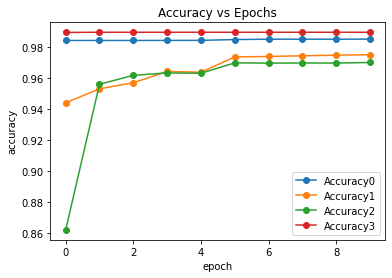

In [30]:
plt.plot(his["val_accuracy_v0"],'-o')
plt.plot(his["val_accuracy_v1"],'-o')
plt.plot(his["val_accuracy_v2"],'-o')
plt.plot(his["val_accuracy_v3"],'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Accuracy0','Accuracy1','Accuracy2','Accuracy3'])
plt.title('Accuracy vs Epochs')

plt.show()

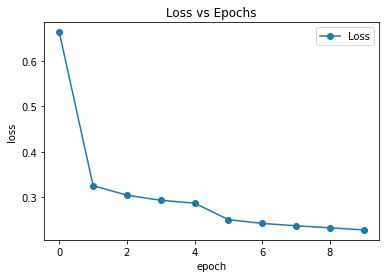

In [31]:
plt.plot(his["train_loss"],'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss'])
plt.title('Loss vs Epochs')

plt.show()